# Tensor flow basics
![alt text](https://www.tensorflow.org/_static/images/tensorflow/logo.png "Tensor flow")

## Tutorial from [here](http://cv-tricks.com/artificial-intelligence/deep-learning/deep-learning-frameworks/tensorflow-tutorial/)

### Load libraries

In [ ]:
import tensorflow as tf
import numpy as np

### Data types

#### 1) Constant - cannot be changed

In [ ]:
a = tf.constant(1.0)
with tf.Session() as sess:
    print(sess.run(a))

#### 2) Variable  - can be changed (they need to be initialized seperately)

In [3]:
b = tf.Variable(2, name='name')
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(b))

2


In [4]:
graph = tf.get_default_graph()
for op in graph.get_operations(): 
    print(op.name)

Const
name/initial_value
name
name/Assign
name/read
init


#### 3) Placeholder - tensors waiting needs to be intialized/fed using feed_dict (usually used for training data)

In [6]:
a = tf.placeholder("float")
b = tf.placeholder("float")
y = tf.multiply(a, b)
 
feed_dict ={a : 2, b : 3}
with tf.Session() as sess:
    print(sess.run(y, feed_dict))

6.0


***
### Simple operations

In [31]:
b = tf.Variable(np.arange(10, 60, 10), name = 't')
# b = tf.Variable([10, 20, 30, 40, 50, 60], name = 't')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.reduce_mean(b))) # calculates mean

a = [[0.1, 0.2, 0.3], [20, 2, 3]]
b = tf.Variable(a, name = 'b')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.argmax(b, axis = 1))) # gets maximum index along rows
    
a = tf.truncated_normal([16,128,128,3])
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print(sess.run(tf.shape(a)))

b=tf.reshape(a,[16,49152])
print(sess.run(tf.shape(b)))

30
[2 0]
[ 16 128 128   3]
[   16 49152]


***
### Simple Linear Regression

In [20]:
trainX = np.linspace(-1, 1, 101)
trainY = 3 * trainX + np.random.randn(*trainX.shape) * 0.33

In [21]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

In [22]:
w = tf.Variable(0.0, name="weights") # initialize weights with 0
y_model = tf.multiply(X, w) # y = w * X

cost = (tf.pow(Y-y_model, 2)) # cost function as squared error
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(cost) # use gradient descent with eta = 0.01

In [23]:
init = tf.global_variables_initializer()

In [24]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(100): # iterations
        for (x, y) in zip(trainX, trainY):
            sess.run(train_op, feed_dict={X: x, Y: y})
    print(sess.run(w))

2.9875


***
### Convolution Neural Networks

#### Layers
1) Convolution Layer
- finds patterns in layers
- parameters: filter size
- typically if 32 x 32 x 3 is passed on a filter of 5 x 5 x 3 then we get 28 x 28 as output
- then we need to do additional padding of 0's to edges to bring back to the same size as input (32 x 32)
- Also we apply multiple filters on each block
  - If 6 filters are applied then it results as follows
  - 28 x 28 x 6 -> PAD -> 32 x 32 x 6
- i.e. N x N = input size, F = filter size, S = stride, P = 0 padding size
  - output = (N - F + 2P)/S + 1
![alt text](http://cv-tricks.com/wp-content/uploads/2017/02/Convolution_schematic.gif.pagespeed.ce.HH8Jo1uguS.gif "Conv layer")

2) Pooling Layer
- used after convolution layer
- Reduces the input size to reduce computation
- max pooling / average pooling is usually used
![alt text](http://cv-tricks.com/wp-content/uploads/2017/02/211x166xpool-1.jpg.pagespeed.ic.IlFJQQcrcC.webp "Pooling")


3) Fully connected layer
- last layer of CNN
- each neuron of this layer recieves an input from all the neurons of previous layer
- matrix multiplication + bias is done over here

#### Our Architecture for simple CNN (dog/cat classifier)
![alt text](http://cv-tricks.com/wp-content/uploads/2017/02/xTensorflow-tutorial-2-1.jpg.pagespeed.ic.cetItSpDJP.webp "Architecture")

In [36]:
#### Read data
import cv2
import os
import glob
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
%matplotlib inline

In [33]:
data_path = 'C:\\Users\\LEP5KOR\\Desktop\\deep learning\\data\\training_data'
img_size = 128
num_channels = 3
num_classes = 2

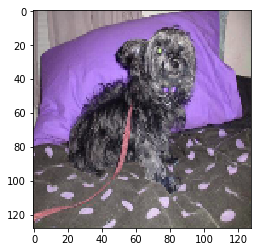

In [38]:
def read_images(path, class_name):
    images = glob.glob(path + '\\' + class_name + '\\*.jpg')
    images_list = []
    images_names = images
    if class_name == 'dogs':
        images_class = [1] * len(images)
    else:
        images_class = [0] * len(images)
    for eachImage in images:
        image = cv2.imread(eachImage)
        image = cv2.resize(image, (128, 128),0,0, cv2.INTER_LINEAR)
        image = image.astype(np.float32)
        image = np.multiply(image, 1.0 / 255.0)
        images_list.append(image)
    return({'images' : images_list, 'names' : images_names, 'class' : images_class})

dogs_data = read_images(data_path, 'dogs')
cats_data = read_images(data_path, 'cats')

plt.imshow(dogs_data['images'][0])
plt.show()

In [39]:
# # independent variables
session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

# # labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [40]:
#  #Network graph params
filter_size_conv1 = 3 
num_filters_conv1 = 32

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64
    
fc_layer_size = 128

In [41]:
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [42]:
def create_convolutional_layer(input, num_input_channels, conv_filter_size, num_filters):  
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')

    layer += biases

    ## We shall be using max-pooling.  
    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)

    return layer

In [43]:
def create_flatten_layer(layer):
    #We know that the shape of the layer will be [batch_size img_size img_size num_channels] 
    # But let's get it from the previous layer.
    layer_shape = layer.get_shape()

    ## Number of features will be img_height * img_width* num_channels. But we shall calculate it in place of hard-coding it.
    num_features = layer_shape[1:4].num_elements()

    ## Now, we Flatten the layer so we shall have to reshape to num_features
    layer = tf.reshape(layer, [-1, num_features])

    return layer

In [44]:
def create_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b.Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [45]:
layer_conv1 = create_convolutional_layer(input = x, num_input_channels=num_channels, conv_filter_size=filter_size_conv1,
               num_filters=num_filters_conv1)
layer_conv2 = create_convolutional_layer(input = layer_conv1, num_input_channels=num_filters_conv1,
               conv_filter_size=filter_size_conv2, num_filters=num_filters_conv2)
layer_conv3= create_convolutional_layer(input=layer_conv2, num_input_channels=num_filters_conv2, conv_filter_size=filter_size_conv3,
               num_filters=num_filters_conv3)

In [46]:
layer_flat = create_flatten_layer(layer_conv3)

In [49]:
layer_fc1 = create_fc_layer(input=layer_flat, num_inputs=layer_flat.get_shape()[1:4].num_elements(), num_outputs=fc_layer_size, use_relu=True)
layer_fc2 = create_fc_layer(input=layer_fc1, num_inputs=fc_layer_size, num_outputs=num_classes, use_relu=False) 
y_pred = tf.nn.softmax(layer_fc2,name='y_pred')
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [51]:
session.run(tf.global_variables_initializer())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                    labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session.run(tf.global_variables_initializer()) 

Tensor("Mean_4:0", shape=(), dtype=float32)


In [52]:
def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [53]:
total_iterations = 0
saver = tf.train.Saver()
def train(num_iteration):
    global total_iterations
    
    for i in range(total_iterations,
                   total_iterations + num_iteration):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)

        
        feed_dict_tr = {x: x_batch,
                           y_true: y_true_batch}
        feed_dict_val = {x: x_valid_batch,
                              y_true: y_valid_batch}

        session.run(optimizer, feed_dict=feed_dict_tr)

        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_val)
            epoch = int(i / int(data.train.num_examples/batch_size))    
            
            show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
            saver.save(session, 'dogs-cats-model') 


    total_iterations += num_iteration

In [ ]:
train(num_iteration=3000)